# Proof of Concept of different binary text classifiers on our data

In the world of ML, there is a vast amount of choice when it comes to which classification method to use.
In this notebook, I will be demonstrating how 4 of the most popular classifiers perform:

- <b>Multinomial Naive Bayes</b>, the 'punching bag' benchmark classifier of the ML world, using class membership probabilities found by feature vector weights, to predict the membership of a new data point,

- <b>Logistic Regression</b>, a method that uses the sigmoid function to transform a representation of how far a new data point lies from a decision boundary found via gradient descent to a class probability,

- <b>K-nearest-neighbours</b>, where the classification of X is a vote of the K nearest items to X,

- <b>SVM</b>, a method that tries to find a hyperplane to seperate classes by treating them as coordinates in an m dimensional space, m being the number of features.

The dataset that we are using in this notebook is very small, containing only 1600 data points, 800 of each class.

However, it is a good dataset to use to produce a POC in this notebook, because the feature extraction is fast, it is balanced, and the labels belong to the gold standard. This means we can cross examine multiple classifiers with multiple features in a fast manner to get a feel for how they perform.

In terms of producing a reliable model to serve on our API, it is not a good choice, as it does not generalize well.

Without further ado, let us begin.

## Data Processing & Feature Extraction

I start by importing some modules for data processing and manipulation, Numpy and Pandas.

I also import a helper function to process the raw data into a frame for us, for the sake of clarity.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Great. Let's take a look at our data:

In [5]:
dataset = tf.keras.utils.get_file(
      fname="opspam.pkl", 
      origin="https://storage.googleapis.com/lucas0/opspam.pkl", 
      extract=False)
df = pd.read_pickle(dataset)
df.head()

,sentiment,review,deceptive
0,0,We stayed at the Schicago Hilton for 4 days an...,1
1,0,Hotel is located 1/2 mile from the train stati...,1
2,0,I made my reservation at the Hilton Chicago be...,1
3,0,"When most people think Hilton, they think luxu...",1
4,0,My husband and I recently stayed stayed at the...,1


Sweet. We have 3 columns: 
- Sentiment (0 is negative, 1 is positive)
- Review, our review text,
- Deceptive (0 is genuine, 1 is deceptive)

Sentiment and Deceptive are pre-labelled for us.
We will be focusing on the deceptive column, the label we wish to predict.

Let's seperate our data from the labels:

In [6]:
X = df['review']
y = np.asarray(df['deceptive'], dtype=int)

These classifiers only work on numeric features, not the strings that our reviews are currently represented by. To represent our reviews as numeric features, we use a Bag of Words model. 

CountVectorizer takes our review and returns a $m$-dimensional array, where $m$ is our vocabularly size and $m_i$ is 1 if the word $i$ appears in the review, 0 if not.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

Lets take a look at the shape of our data after this transformation.

In [8]:
print(cv.fit_transform(X).shape)

(1600, 9571)


In this example, 1600 represents the number of reviews in our data, and 9571 the number of words (size of vocab.)
Let's see what happens if we remove stop words:

In [9]:
cv = CountVectorizer(stop_words='english')
print(cv.fit_transform(X).shape)

(1600, 9284)


That will help our classifier slightly. Stop words generally don't contribute anything to class membership, and add noise.

Here's what our first review looks like in count vector format:

In [10]:
print((cv.fit_transform(X)[0]))

  (0, 3266)	1
  (0, 337)	1
  (0, 7482)	1
  (0, 9210)	1
  (0, 1754)	1
  (0, 9023)	1
  (0, 4085)	1
  (0, 3744)	1
  (0, 4770)	1
  (0, 2829)	1
  (0, 6507)	1
  (0, 2535)	1
  (0, 4343)	1
  (0, 5252)	1
  (0, 2172)	1
  (0, 699)	1
  (0, 4902)	1
  (0, 2859)	1
  (0, 8777)	1
  (0, 1514)	1
  (0, 6982)	1
  (0, 5775)	1
  (0, 2603)	1
  (0, 3518)	1
  (0, 4727)	1
  :	:
  (0, 6979)	2
  (0, 731)	1
  (0, 4143)	4
  (0, 7848)	2
  (0, 8566)	1
  (0, 6886)	1
  (0, 9231)	1
  (0, 387)	1
  (0, 8374)	1
  (0, 8174)	1
  (0, 889)	2
  (0, 3154)	1
  (0, 4839)	1
  (0, 1719)	1
  (0, 571)	1
  (0, 3728)	1
  (0, 2849)	1
  (0, 5563)	1
  (0, 7104)	1
  (0, 1943)	1
  (0, 5528)	1
  (0, 2311)	1
  (0, 4050)	3
  (0, 7137)	1
  (0, 7849)	1


ie. the 4050'th word in the vocab appeared in the first review 3 times.

Now, let's apply another transformation. 

$Tf$ is term frequency, and corresponds to how many times a word appears in a review. The higher, more chances are that this particular review is relevant to this word.  

$df$ is the number of reviews the word occured in. The higher, the less we should weight the review because of the word. (If a word occurs in a large number of reviews , it wont play important role in finding out reviews relevant to  the word).

Therefore, we use the calculation $tf * \frac {1} {df} $.

This is known as $Tf-idf$, and provides a better representation of our data than just word counts. It weights words that are important to a review's classification higher.

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()

Let's transform our first count vector and see what it looks like now.

In [12]:
print(tfidf.fit_transform(cv.fit_transform(X)[0]))

  (0, 9246)	0.07738232325341368
  (0, 9231)	0.07738232325341368
  (0, 9210)	0.07738232325341368
  (0, 9201)	0.07738232325341368
  (0, 9023)	0.07738232325341368
  (0, 9014)	0.07738232325341368
  (0, 8848)	0.07738232325341368
  (0, 8813)	0.07738232325341368
  (0, 8777)	0.07738232325341368
  (0, 8566)	0.07738232325341368
  (0, 8419)	0.07738232325341368
  (0, 8401)	0.15476464650682736
  (0, 8374)	0.07738232325341368
  (0, 8316)	0.15476464650682736
  (0, 8174)	0.07738232325341368
  (0, 8059)	0.07738232325341368
  (0, 7849)	0.07738232325341368
  (0, 7848)	0.15476464650682736
  (0, 7761)	0.07738232325341368
  (0, 7580)	0.07738232325341368
  (0, 7482)	0.07738232325341368
  (0, 7249)	0.07738232325341368
  (0, 7201)	0.07738232325341368
  (0, 7137)	0.07738232325341368
  (0, 7104)	0.07738232325341368
  :	:
  (0, 2311)	0.07738232325341368
  (0, 2172)	0.07738232325341368
  (0, 1943)	0.07738232325341368
  (0, 1879)	0.07738232325341368
  (0, 1754)	0.07738232325341368
  (0, 1721)	0.15476464650682736
  

## Finding Optimal Classifier Parameters

Now for the fun stuff! Let's import all of our classifiers listed above:

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm

Pipelines allow us to combine feature extractors with classifiers to make life easier.

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
scoring = {
    'acc': 'accuracy',
    'auroc': 'roc_auc',
    'f1': 'f1'
}

### Naive Bayes

There aren't much different things we can try with Naive Bayes, however we can see the difference of unigrams to bigrams.

In [29]:
from sklearn.model_selection import cross_val_score, cross_validate
cv_unigram = CountVectorizer(stop_words='english', ngram_range = (0, 1))
cv_bigram = CountVectorizer(stop_words='english', ngram_range = (1, 2))
mnb = MultinomialNB(alpha=2)

models = []

models.append(('Bigram MNB tfidf', Pipeline([ ('cv', cv_bigram), ('tfidf', tfidf), ('mnb', mnb) ])))
models.append(('Unigram MNB tfidf', Pipeline([ ('cv', cv_unigram), ('tfidf', tfidf), ('mnb', mnb) ])))


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model[0]
  accuracies = cross_validate(model[1], X, y, scoring=scoring, cv=CV)
  for fold_idx, accuracy in enumerate(zip(accuracies['test_acc'], accuracies['test_auroc'], accuracies['test_f1'])):
    entries.append((model_name, fold_idx, accuracy[0], accuracy[1], accuracy[2]))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'auroc', 'f1'])

In [30]:
cv_df.groupby('model_name').accuracy.mean()

model_name
Bigram MNB tfidf     0.853125
Unigram MNB tfidf    0.848125
Name: accuracy, dtype: float64

In [31]:
cv_df.groupby('model_name').auroc.mean()

model_name
Bigram MNB tfidf     0.939391
Unigram MNB tfidf    0.934016
Name: auroc, dtype: float64

In [32]:
cv_df.groupby('model_name').f1.mean()

model_name
Bigram MNB tfidf     0.862345
Unigram MNB tfidf    0.856780
Name: f1, dtype: float64

Looks like our Bigram-trained MNB is better.

### K-Nearest Neighbors

Let's see how many neighbors we should use for our k-NN classifier.

In [33]:
from sklearn.model_selection import train_test_split

cv_knn = CountVectorizer(stop_words='english', ngram_range = (0, 1))

# Setup arrays to store training and test accuracies
neighbors = np.arange(5, 22)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Split up the data into train and test for this problem
X_train = tfidf.fit_transform(cv_knn.fit_transform(X_train))
X_test = tfidf.transform(cv_knn.transform(X_test))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

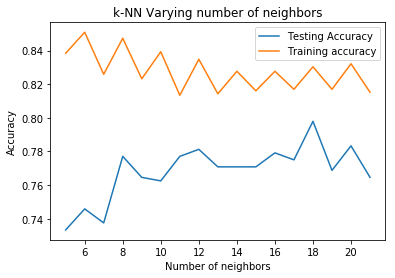

In [14]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

18 seems to be our optimal number of neighbors.

### Support Vector Machine

There's a couple of different types of SVM with a bunch of different parameters. NuSVC is the classic SVC except you can tweak the number of support vectors. Let's compare the different types, using bigram tf-idf vectors as features.

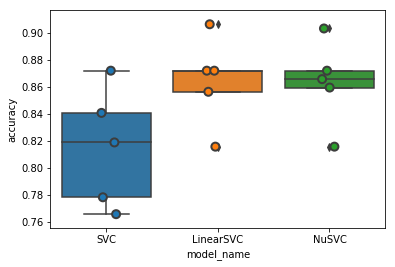

model_name
LinearSVC    0.864375
NuSVC        0.863125
SVC          0.815000
Name: accuracy, dtype: float64

In [36]:
# Setup arrays to store models and param sets
cv = CountVectorizer(stop_words='english', ngram_range = (1, 2))

models = []

models.append(('SVC', Pipeline([ ('cv', cv), ('tfidf', tfidf), ('svm', svm.SVC(kernel="sigmoid", gamma='scale', random_state=42)) ])))
models.append(('LinearSVC', Pipeline([ ('cv', cv), ('tfidf', tfidf), ('svm', svm.LinearSVC(random_state=42)) ])))
models.append(('NuSVC', Pipeline([ ('cv', cv), ('tfidf', tfidf), ('svm', svm.NuSVC(kernel='sigmoid', gamma='scale', random_state=42)) ])))

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model[0]
  accuracies = cross_validate(model[1], X, y, scoring=scoring, cv=CV)
  for fold_idx, accuracy in enumerate(zip(accuracies['test_acc'], accuracies['test_auroc'], accuracies['test_f1'])):
    entries.append((model_name, fold_idx, accuracy[0], accuracy[1], accuracy[2]))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'auroc', 'f1'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, edgecolor="gray", linewidth=2)
plt.show()

In [37]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC    0.864375
NuSVC        0.863125
SVC          0.815000
Name: accuracy, dtype: float64

In [38]:
cv_df.groupby('model_name').auroc.mean()

model_name
LinearSVC    0.939484
NuSVC        0.937883
SVC          0.931953
Name: auroc, dtype: float64

In [39]:
cv_df.groupby('model_name').f1.mean()

model_name
LinearSVC    0.865553
NuSVC        0.863590
SVC          0.786551
Name: f1, dtype: float64

Looks like the LinearSVC is our best option.

## Cross Classifier Comparison

Now we create all of our pipelines, one for each classifier.

In [41]:
nbayes = Pipeline([ ('cv', cv), ('tfidf', tfidf), ('nbayes', MultinomialNB()) ])
logreg = Pipeline([ ('cv', cv), ('tfidf', tfidf), ('logreg', LogisticRegression(random_state=42, solver='liblinear')) ])
knn = Pipeline([ ('cv', cv_knn), ('tfidf', tfidf), ('knn', KNeighborsClassifier(n_neighbors=18)) ])
svc = Pipeline([ ('cv', cv), ('tfidf', tfidf), ('svm', svm.LinearSVC(random_state=42)) ])

models = {'Naive Bayes': nbayes, 'Log. Regression':logreg, 'k-NN':knn, 'SVC':svc}

For getting an accurate test/train split, we split our data up using 10 fold cross validation.

Now lets get our accuracy scores!

In [43]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for name, model in models.items():
  model_name = name
  accuracies = cross_validate(model, X, y, scoring=scoring, cv=CV)
  for fold_idx, accuracy in enumerate(zip(accuracies['test_acc'], accuracies['test_auroc'], accuracies['test_f1'])):
    entries.append((model_name, fold_idx, accuracy[0], accuracy[1], accuracy[2]))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy', 'auroc', 'f1'])

Let's plot the 4 classifier accuracies against each other using the matplotlib library Seaborn.

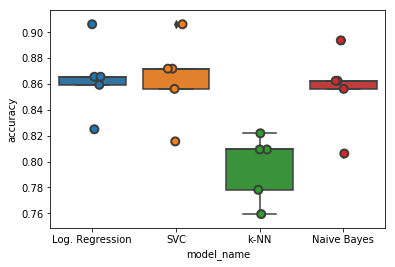

In [44]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [45]:
cv_df.groupby('model_name').accuracy.mean()

model_name
Log. Regression    0.864375
Naive Bayes        0.856250
SVC                0.864375
k-NN               0.795625
Name: accuracy, dtype: float64

In [46]:
cv_df.groupby('model_name').auroc.mean()

model_name
Log. Regression    0.936508
Naive Bayes        0.938297
SVC                0.939484
k-NN               0.881641
Name: auroc, dtype: float64

In [47]:
cv_df.groupby('model_name').f1.mean()

model_name
Log. Regression    0.865711
Naive Bayes        0.862705
SVC                0.865553
k-NN               0.813062
Name: f1, dtype: float64

As we can see, the SVM worked best, whereas the k-NN algorithm does relatively poorly.